In [1]:
import sys

sys.path.append("../")

from src.common_functions import *
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import sys
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve
import collections
from scipy.spatial import ConvexHull
from scipy.special import betainc
import scipy.special as ss


# 1. Load data, prep & train test split

In [3]:
df = pd.read_csv("../datasets/churn/fin_churn.csv" )
df = df.rename(columns=dict(zip(df.columns, list(map(to_snake_case, df.columns)))))
df.head()
RAW_DATA_PATH = "../datasets/churn/fin_churn.csv"
DATASET_NAME = Path(RAW_DATA_PATH).stem

In [4]:
pd.set_option('display.max_columns', None)
df.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
num_rows = len(df)
print(f'The dataset has {num_rows} rows.')

The dataset has 10000 rows.


In [6]:
df.exited.value_counts()/df.shape[0]*100

exited
0    79.63
1    20.37
Name: count, dtype: float64

In [7]:
70.63/20.37

3.467353951890034

In [8]:
20.37/70.63

0.28840436075322107

In [9]:
df.isna().any()

row_number          False
customer_id         False
surname             False
credit_score        False
geography           False
gender              False
age                 False
tenure              False
balance             False
num_of_products     False
has_cr_card         False
is_active_member    False
estimated_salary    False
exited              False
dtype: bool

In [10]:
y = "exited"

# some generic cleaning

COLUMNS_TO_DROP = ["customer_id", "surname"]
assert df[y].isna().any() == False
raw_features = df.drop(COLUMNS_TO_DROP, axis=1)

# ML tuning

train, test = train_test_split(
    raw_features, test_size=0.2, random_state=0, stratify=df[y])

fit_le = LabelEncoder().fit(train[y])

In [11]:
param_grid = {
    'logistic__penalty': ['l2'],
    'logistic__C': [1, 10, 100, 1000],
    'pca__n_components': [6,8,10,12],
    'under__sampling_strategy': [0.3, 0.5, 0.7, 1],
    'over__sampling_strategy': [0.5, 0.7, 1]
}

model = LogisticRegression()

MODEL_NAME = 'logistic'

grid = sklearn_gridsearch_using_pipeline(
    train, y_col_name=y, model=model, fit_le=fit_le, model_name='logistic', param_grid=param_grid, verbose=1)
best_pipeline_log_reg = grid.best_estimator_
best_pipeline_log_reg

Fitting 5 folds for each of 192 candidates, totalling 960 fits


c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
480 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
480 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^

Best score: 0.771937090079071
Best parameters: {'logistic__C': 1, 'logistic__penalty': 'l2', 'over__sampling_strategy': 1, 'pca__n_components': 12, 'under__sampling_strategy': 0.7}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['row_number', 'credit_score',
                                                   'age', 'tenure', 'balance',
                                                   'num_of_products',
                                                   'has_cr_card',
                                                   'is_active_member',
                                                   'estimated_salary']),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['geography', 'gender'])])),
                ('under', RandomUnderSampler(sampling_strategy=0.7)),
                ('over', SMOTE(sampling_strategy=1)),
                ('pca', PCA(n_components=12)),
                ('logistic', LogisticRegression(C=1))])

In [12]:
write_pipeline(best_pipeline_log_reg, MODEL_NAME, DATASET_NAME)

Op de k-de fold als test set over alle k-folds de mean van test-metric = "roc_auc"

In [13]:
COLUMNS = ["under__sampling_strategy", "over__sampling_strategy", "pca__n_components", f"{MODEL_NAME}__C", f"{MODEL_NAME}__penalty", "roc_auc_mean", "roc_auc_std"]

pd.concat([
    pd.DataFrame(grid.cv_results_["params"]),
    pd.DataFrame(grid.cv_results_["mean_test_score"], columns=["roc_auc_mean"]),
    pd.DataFrame(grid.cv_results_["std_test_score"], columns=["roc_auc_std"])
    ],axis=1).dropna(subset=["roc_auc_mean", "roc_auc_std"])[COLUMNS].sort_values(by=COLUMNS)

,under__sampling_strategy,over__sampling_strategy,pca__n_components,logistic__C,logistic__penalty,roc_auc_mean,roc_auc_std
0,0.3,0.5,6,1,l2,0.700184,0.015187
48,0.3,0.5,6,10,l2,0.688445,0.028806
96,0.3,0.5,6,100,l2,0.697553,0.007035
144,0.3,0.5,6,1000,l2,0.691946,0.024151
4,0.3,0.5,8,1,l2,0.752743,0.007235
...,...,...,...,...,...,...,...
186,0.7,1.0,10,1000,l2,0.766486,0.006239
46,0.7,1.0,12,1,l2,0.771937,0.007842
94,0.7,1.0,12,10,l2,0.771471,0.007686
142,0.7,1.0,12,100,l2,0.770642,0.007687


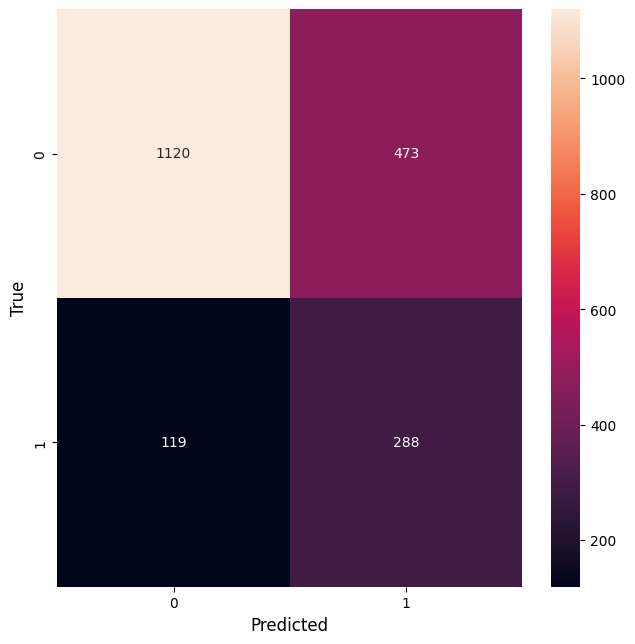

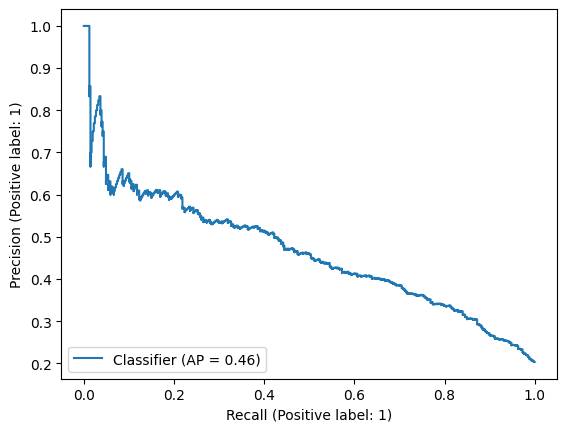

In [14]:
evaluate_model(best_pipeline_log_reg, fit_le=fit_le, test=test, y_col_name=y, model_name='logistic')

In [15]:
MODEL_NAME='logistic'
best_pipeline_log_reg = load_pipeline(model_name=MODEL_NAME, dataset_name=DATASET_NAME)

In [16]:
param_grid_xgb = {
    'xgb__objective': ['binary:logistic'],
    'xgb__min_child_weight': [1, 5, 10],
    'xgb__gamma': [0.5, 1, 1.5, 2, 5],
    'xgb__subsample': [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.6, 0.8, 1.0],
    'xgb__max_depth': [3, 4, 5],
    'pca__n_components': [14, 20, 25, 30, 35, 50, 65],
    'under__sampling_strategy': [0.1, 0.2, 0.3, 0.5, 0.7, 1],
    'over__sampling_strategy': [0.2, 0.3, 0.4, 0.5, 0.7, 1]
}

xgb = XGBClassifier()

MODEL_NAME = "xgb"

grid = sklearn_gridsearch_using_pipeline(
    train, y_col_name=y, fit_le=fit_le, model_name=MODEL_NAME, model=xgb, param_grid=param_grid_xgb, n_folds=5, verbose=1, randomized= True)
best_pipeline_xgb = grid.best_estimator_
best_pipeline_xgb

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
45 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^

Best score: 0.8367337307740463
Best parameters: {'xgb__subsample': 0.8, 'xgb__objective': 'binary:logistic', 'xgb__min_child_weight': 1, 'xgb__max_depth': 3, 'xgb__gamma': 1, 'xgb__colsample_bytree': 0.6, 'under__sampling_strategy': 0.5, 'pca__n_components': 14, 'over__sampling_strategy': 1}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['row_number', 'credit_score',
                                                   'age', 'tenure', 'balance',
                                                   'num_of_products',
                                                   'has_cr_card',
                                                   'is_active_member',
                                                   'estimated_salary']),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strate...
                               feature_types=None, gamma=1, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, predictor=None,
                               random_state=None, ...))])

In [17]:
write_pipeline(best_pipeline_xgb, MODEL_NAME, DATASET_NAME)

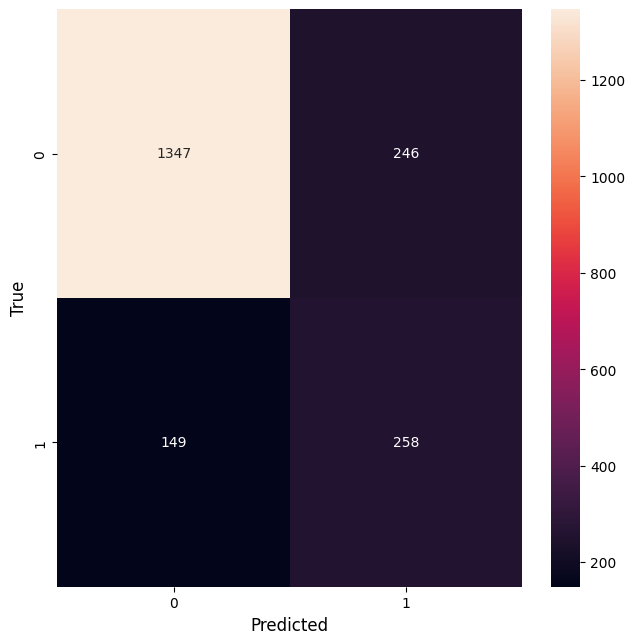

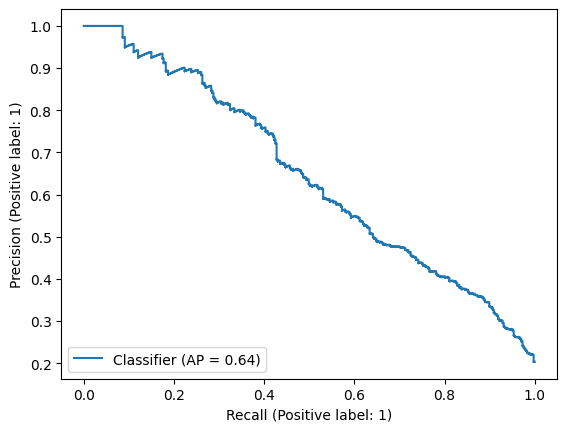

In [18]:
evaluate_model(best_pipeline_xgb, fit_le=fit_le, test=test, y_col_name=y, model_name=MODEL_NAME)

In [19]:
MODEL_NAME='xgb'
best_pipeline_xgb = load_pipeline(model_name=MODEL_NAME, dataset_name=DATASET_NAME)

# cost evaluation metrics

In [20]:
test_predictions_log = test.copy(deep=True)
test_predictions_log["y_predicted"] = best_pipeline_log_reg.predict(test_predictions_log.drop(y, axis=1))
test_predictions_log["churn_encoded"] = fit_le.transform(test_predictions_log["exited"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_log['A'] = impute.fit_transform(
    (test_predictions_log["balance"]*test_predictions_log["credit_score"]).to_frame())[:, 0]
scaler = MinMaxScaler()

# Fit and transform the cb_cyolumn using the scaler
test_predictions_log['A'] = scaler.fit_transform(test_predictions_log['A'].values.reshape(-1, 1))


# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_log['instance_cost'] = test_predictions_log.apply(lambda row: instance_dependent_cost_churn(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_log["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_log["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_log[['exited', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_log['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_log['instance_cost'].sum()/len(test_predictions_log))

Test cost/loss = 715.
 total cost/loss average :  0.35758627390284237


In [21]:
print(test_predictions_log[['exited', "A", 'instance_cost', 'y_predicted']].iloc[31:60])
print(test[y])

      exited         A  instance_cost  y_predicted
1690       0  0.208530       0.000000            0
6514       0  0.000000       0.000000            0
5741       0  0.479974       0.000000            0
4478       0  0.000000       0.000000            0
3729       0  0.000000       0.000000            0
6626       0  0.598616       1.197232            1
9089       0  0.308224       0.000000            0
1868       0  0.366322       0.000000            0
6676       0  0.000000       0.000000            0
8241       0  0.000000       0.000000            0
9441       0  0.359994       0.000000            0
9690       1  0.687904       8.254851            0
5032       0  0.402149       0.804297            1
2381       1  0.630841       0.000000            1
2112       0  0.000000       0.000000            0
2025       0  0.000000       0.000000            0
9118       0  0.000000       0.000000            0
1525       0  0.454388       0.000000            0
4250       0  0.327531       0.

In [22]:
test_predictions_xgb = test.copy(deep=True)
test_predictions_xgb["y_predicted"] = best_pipeline_xgb.predict(test_predictions_xgb.drop(y, axis=1))
test_predictions_xgb["churn_encoded"] = fit_le.transform(test_predictions_xgb["exited"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_xgb['A'] = impute.fit_transform(
    (test_predictions_xgb["balance"]*test_predictions_xgb["credit_score"]).to_frame())[:, 0]
scaler = MinMaxScaler()

# Fit and transform the cb_column using the scaler
test_predictions_xgb['A'] = scaler.fit_transform(test_predictions_xgb['A'].values.reshape(-1, 1))


# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_xgb['instance_cost'] = test_predictions_xgb.apply(lambda row: instance_dependent_cost_churn(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_xgb["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_xgb["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_xgb[['exited', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_xgb['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_xgb['instance_cost'].sum()/len(test_predictions_xgb))

Test cost/loss = 726.
 total cost/loss average :  0.3630336111341645


In [23]:
print(test_predictions_xgb[['exited', "A", 'instance_cost', 'y_predicted']].iloc[31:60])
print(test[y])

      exited         A  instance_cost  y_predicted
1690       0  0.208530       0.000000            0
6514       0  0.000000       0.000000            0
5741       0  0.479974       0.000000            0
4478       0  0.000000       0.000000            0
3729       0  0.000000       0.000000            0
6626       0  0.598616       1.197232            1
9089       0  0.308224       0.000000            0
1868       0  0.366322       0.000000            0
6676       0  0.000000       0.000000            0
8241       0  0.000000       0.000000            0
9441       0  0.359994       0.000000            0
9690       1  0.687904       8.254851            0
5032       0  0.402149       0.804297            1
2381       1  0.630841       7.570096            0
2112       0  0.000000       0.000000            0
2025       0  0.000000       0.000000            0
9118       0  0.000000       0.000000            0
1525       0  0.454388       0.000000            0
4250       0  0.327531       0.

# AMC metric

Decision Threshold: 0.01, Test cost/loss = 836.28
Decision Threshold: 0.02, Test cost/loss = 836.28
Decision Threshold: 0.03, Test cost/loss = 836.28


Decision Threshold: 0.04, Test cost/loss = 836.28
Decision Threshold: 0.05, Test cost/loss = 836.28
Decision Threshold: 0.06, Test cost/loss = 836.28
Decision Threshold: 0.07, Test cost/loss = 832.65
Decision Threshold: 0.08, Test cost/loss = 831.63
Decision Threshold: 0.09, Test cost/loss = 831.34
Decision Threshold: 0.10, Test cost/loss = 828.33
Decision Threshold: 0.11, Test cost/loss = 822.69
Decision Threshold: 0.12, Test cost/loss = 823.64
Decision Threshold: 0.13, Test cost/loss = 814.51
Decision Threshold: 0.14, Test cost/loss = 813.63
Decision Threshold: 0.15, Test cost/loss = 813.22
Decision Threshold: 0.16, Test cost/loss = 803.89
Decision Threshold: 0.17, Test cost/loss = 802.14
Decision Threshold: 0.18, Test cost/loss = 794.02
Decision Threshold: 0.19, Test cost/loss = 779.48
Decision Threshold: 0.20, Test cost/loss = 778.09
Decision Threshold: 0.21, Test cost/loss = 766.03
Decision Threshold: 0.22, Test cost/loss = 762.09
Decision Threshold: 0.23, Test cost/loss = 749.05

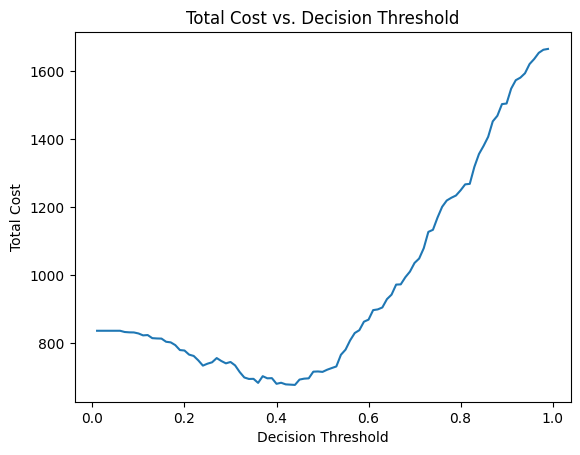

In [24]:
cb_column = 'A'
test_predictions_log['y_predicted_proba_log']= best_pipeline_log_reg.predict_proba(test_predictions_log.drop(y, axis=1))[:, 1]
best_threshold_log, AMC_log, lowest_cost_log = compute_best_threshold(test_predictions_log, best_pipeline_log_reg, y,cb_column,y_predicted_proba_col_name="y_predicted_proba_log" )

Decision Threshold: 0.01, Test cost/loss = 833.77
Decision Threshold: 0.02, Test cost/loss = 812.77
Decision Threshold: 0.03, Test cost/loss = 805.95
Decision Threshold: 0.04, Test cost/loss = 794.48
Decision Threshold: 0.05, Test cost/loss = 772.56
Decision Threshold: 0.06, Test cost/loss = 760.15
Decision Threshold: 0.07, Test cost/loss = 751.69
Decision Threshold: 0.08, Test cost/loss = 743.04
Decision Threshold: 0.09, Test cost/loss = 727.05
Decision Threshold: 0.10, Test cost/loss = 725.85
Decision Threshold: 0.11, Test cost/loss = 719.95
Decision Threshold: 0.12, Test cost/loss = 696.76
Decision Threshold: 0.13, Test cost/loss = 698.07
Decision Threshold: 0.14, Test cost/loss = 678.21
Decision Threshold: 0.15, Test cost/loss = 678.77
Decision Threshold: 0.16, Test cost/loss = 665.13
Decision Threshold: 0.17, Test cost/loss = 656.82
Decision Threshold: 0.18, Test cost/loss = 645.48
Decision Threshold: 0.19, Test cost/loss = 644.20
Decision Threshold: 0.20, Test cost/loss = 637.00


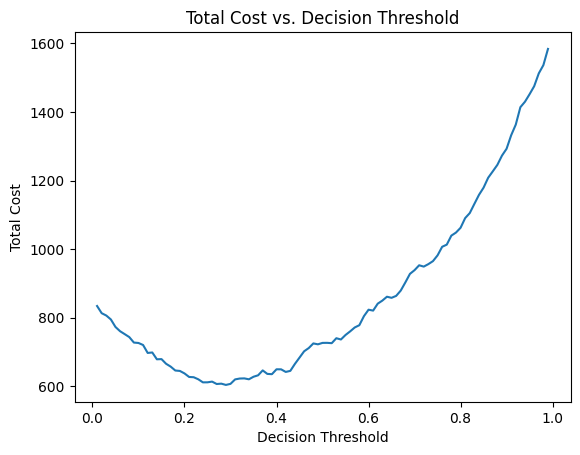

In [25]:
test_predictions_xgb['y_predicted_proba_xgb']= best_pipeline_xgb.predict_proba(test_predictions_xgb.drop(y, axis=1))[:, 1]
best_threshold_xgb, AMC_xgb, lowest_cost_xgb = compute_best_threshold(test_predictions_xgb, best_pipeline_xgb, y, cb_column, y_predicted_proba_col_name="y_predicted_proba_xgb")

# E-AMC metric

In [26]:
test_predictions_log = add_eap_ep(
    train=train, 
    test=test_predictions_log, 
    y_col_name=y, 
    best_pipeline=best_pipeline_log_reg, 
    cb_column=cb_column, 
    predicted_proba_col_name='y_predicted_proba_log', 
    churn_label= 1, 
    instance_dependent_cost_type="churn")
test_predictions_xgb = add_eap_ep(
    train=train, 
    test=test_predictions_xgb, 
    y_col_name=y, 
    best_pipeline=best_pipeline_xgb, 
    cb_column=cb_column, 
    predicted_proba_col_name="y_predicted_proba_xgb", 
    churn_label=1, 
    instance_dependent_cost_type="churn")


c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:318: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EAP'] = test_actual_label_0[predicted_proba_col_name]*test_actual_label_0['FP'] + \
c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:320: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EP'] = estim

In [27]:
# test_predictions_log = add_eap_ep(train, test_predictions_log, y, best_pipeline_log_reg, cb_column, model_name="log", instance_dependent_cost_type="churn")
# test_predictions_xgb = add_eap_ep(train, test_predictions_xgb, y, best_pipeline_xgb, cb_column, model_name="xgb", instance_dependent_cost_type="churn")

In [28]:
test_predictions_log

,row_number,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,y_predicted,churn_encoded,A,instance_cost,y_predicted_decoded,y_predicted_proba_log,TN,FN,FP,TP,EAP,EP
8167,8168,713,Germany,Female,24,7,147687.24,1,1,1,121592.50,0,0,0,0.601333,0.000000,0,0.273530,0,7.215993,1.202666,0,0.328965,0.245043
4747,4748,663,Spain,Male,64,6,0.00,2,0,1,15876.52,0,1,0,0.000000,0.000000,1,0.619562,0,0.000000,0.000000,0,0.000000,0.000000
2090,2091,667,Spain,Male,39,9,0.00,2,1,0,68873.80,0,0,0,0.000000,0.000000,0,0.347940,0,0.000000,0.000000,0,0.000000,0.000000
3298,3299,558,Germany,Male,25,10,111363.10,2,1,0,197264.35,0,0,0,0.354861,0.000000,0,0.388409,0,4.258328,0.709721,0,0.275662,0.144606
9485,9486,850,Spain,Male,37,4,88141.10,1,1,0,109659.12,0,0,0,0.427838,0.000000,0,0.329236,0,5.134061,0.855677,0,0.281719,0.174344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8379,8380,434,Spain,Male,55,6,0.00,1,0,1,73562.05,1,1,1,0.000000,0.000000,1,0.525547,0,0.000000,0.000000,0,0.000000,0.000000
7223,7224,799,Germany,Male,31,9,154586.92,1,0,1,88604.89,1,0,1,0.705345,8.464146,0,0.246626,0,8.464146,1.410691,0,6.376671,6.739576
1046,1047,807,Spain,Female,42,1,0.00,1,1,0,16500.66,1,1,1,0.000000,0.000000,1,0.576789,0,0.000000,0.000000,0,0.000000,0.000000
1487,1488,710,Spain,Female,51,4,93656.95,1,0,1,141400.51,1,1,1,0.379735,4.556821,1,0.603741,0,4.556821,0.759470,0,1.805681,3.628369


In [29]:
test_predictions_xgb

,row_number,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,y_predicted,churn_encoded,A,instance_cost,y_predicted_decoded,y_predicted_proba_xgb,TN,FN,FP,TP,EAP,EP
8167,8168,713,Germany,Female,24,7,147687.24,1,1,1,121592.50,0,0,0,0.601333,0.000000,0,0.343596,0,7.215993,1.202666,0,0.413232,0.245043
4747,4748,663,Spain,Male,64,6,0.00,2,0,1,15876.52,0,0,0,0.000000,0.000000,0,0.309799,0,0.000000,0.000000,0,0.000000,0.000000
2090,2091,667,Spain,Male,39,9,0.00,2,1,0,68873.80,0,0,0,0.000000,0.000000,0,0.045992,0,0.000000,0.000000,0,0.000000,0.000000
3298,3299,558,Germany,Male,25,10,111363.10,2,1,0,197264.35,0,0,0,0.354861,0.000000,0,0.024218,0,4.258328,0.709721,0,0.017188,0.144606
9485,9486,850,Spain,Male,37,4,88141.10,1,1,0,109659.12,0,0,0,0.427838,0.000000,0,0.086157,0,5.134061,0.855677,0,0.073723,0.174344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8379,8380,434,Spain,Male,55,6,0.00,1,0,1,73562.05,1,0,1,0.000000,0.000000,0,0.302658,0,0.000000,0.000000,0,0.000000,0.000000
7223,7224,799,Germany,Male,31,9,154586.92,1,0,1,88604.89,1,1,1,0.705345,8.464146,1,0.594095,0,8.464146,1.410691,0,3.435637,6.739576
1046,1047,807,Spain,Female,42,1,0.00,1,1,0,16500.66,1,1,1,0.000000,0.000000,1,0.740340,0,0.000000,0.000000,0,0.000000,0.000000
1487,1488,710,Spain,Female,51,4,93656.95,1,0,1,141400.51,1,1,1,0.379735,4.556821,1,0.698791,0,4.556821,0.759470,0,1.372557,3.628369


In [30]:
print(test_predictions_log['EAP'].sum())
print(test_predictions_log['EP'].sum())


print('EAP : ', test_predictions_log['EAP'].sum()/len(test_predictions_log))
print('EP : ', test_predictions_log['EP'].sum()/len(test_predictions_log))

967.148300357933
1497.296708062372
EAP :  0.4835741501789665
EP :  0.748648354031186


In [31]:
print(test_predictions_xgb['EAP'].sum())
print(test_predictions_xgb['EP'].sum())


print('EAP : ', test_predictions_xgb['EAP'].sum()/len(test_predictions_xgb))
print('EP : ', test_predictions_xgb['EP'].sum()/len(test_predictions_xgb))

862.9051724829621
1497.296708062372
EAP :  0.4314525862414811
EP :  0.748648354031186


# emp and mp for non instance based 

In [32]:
# test_predictions = test.copy(deep=True)
# test_predictions["y_predicted_proba"] = best_pipeline_log_reg.predict_proba(test_predictions.drop(y, axis=1))[:, 1]
# test_predictions["churn_encoded"] = fit_le.transform(test_predictions["exited"])
# def __empRocInfo(probability_scores, true_class_labels):
    
#     # test['y_predicted_proba'] =  log_best.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]

    
#     arguments_list = [test_predictions['y_predicted_proba'], test_predictions["churn_encoded"]]
#     factor_array = []
#     n_0 = 0
#     number_of_factors = 0
    
#     def linear_line(m, x, b):
#         return m*x + b
    
    
#     for i in range(0, len(arguments_list)):
#         if (type(arguments_list[i]) == pd.Series):
#             arguments_list[i] = arguments_list[i].to_numpy().reshape(1,-1)[0]
#         if (type(arguments_list[i]) == np.matrix):
#             arguments_list[i] = np.asarray(arguments_list[i]).reshape(1,-1)[0]
#         if (type(arguments_list[i]) == list):
#             arguments_list[i] = np.array(arguments_list[i]).reshape(1,-1)[0]
    
#     for i in range(0, len(arguments_list[1])):
#         if (arguments_list[1][i] not in factor_array):
#             factor_array.append(arguments_list[1][i])
#             number_of_factors = number_of_factors + 1
            
#     if (number_of_factors > 2):
#         sys.exit("More than 2 classes in true class labels, data not suitable for binary classification")


#     ### Checking to ensure that the probability scores array is the same length as the true class labels array ###

#     if (len(arguments_list[0]) != len(arguments_list[1])):
#         sys.exit("Length of input arrays probability_scores and true_class_labels are not equal")

# ### Checking that there are no invalid probabilities in the probability scores array ###

#     for i in range(0, len(arguments_list[0])):
#         if (arguments_list[0][i] > 1 or arguments_list[0][i] < 0):
#             sys.exit("Invalid Probability Score: You have a probability outside [0,1]")

# ### Counting the number of positive cases in the true class values array ###

#     for i in range(0, len(arguments_list[1])):
#         if (arguments_list[1][i] == 1):
#             n_0 +=  1
            
# ### Calculating metrics ###

#     total_number_of_observations = len(arguments_list[1])
#     n_1 = total_number_of_observations - n_0
#     pi_1 = n_1 / total_number_of_observations
#     pi_0 = n_0 / total_number_of_observations
#     fpr, tpr, thresholds = roc_curve(arguments_list[1], arguments_list[0])
#     roc_output = np.c_[fpr, tpr]
#     hull = ConvexHull(roc_output)
#     vertices = []
    
#     for k in hull.vertices:
#         if roc_output[k,1] >= linear_line(1, roc_output[k,0], 0):
#             vertices.append(k)
            
#     F_1 = roc_output[vertices, 0]
#     F_1 = np.sort(F_1)
#     F_0 = roc_output[vertices, 1]
#     F_0 = np.sort(F_0)
    
#     return n_0, n_1, pi_0, pi_1, F_0, F_1


In [33]:
# test_predictions = test.copy(deep=True)
# test_predictions["y_predicted_proba"] = best_pipeline_log_reg.predict_proba(test_predictions.drop(y, axis=1))[:, 1]
# test_predictions["churn_encoded"] = fit_le.transform(test_predictions["exited"])

# def empChurn(probability_scores, true_class_labels, alpha=6, beta=14, clv=177.22, d=10, f=1, print_output=False, return_output=True, rounding=None):
     
     
#     def B(a, b, X):
        
        
#         return betainc(a, b, X)* ss.beta(a, b)

#         ### Initializing constants and variables for rest of function ###

#     roc = __empRocInfo(test_predictions["y_predicted_proba"], test_predictions["churn_encoded"])
#     E_GAMMA = alpha / (alpha + beta)
#     DELTA = d / clv
#     PHI = f / clv
        
#     ### Calculating MP and MP fraction ###
#     '''
#     n_0, n_1, pi_0, pi_1, F_0, F_1
#     gamma values = pi_0 (delta * phi)
#     '''
#     gamma_values = np.append(0, (roc[3]*(DELTA + PHI)*np.diff(roc[5]) + roc[2]*PHI*np.diff(roc[4])) / (roc[2]*(1 - DELTA)*np.diff(roc[4])))
#     gamma_values = np.append(gamma_values[gamma_values < 1], 1)
#     ind_E = np.max(np.where((gamma_values < E_GAMMA) == True))
#     MP = clv*((E_GAMMA*(1 - DELTA) - PHI)*roc[2]*(roc[4])[ind_E] - (DELTA + PHI)*roc[3]*(roc[5])[ind_E])
#     MP_fraction = roc[2]*(roc[4])[ind_E] + roc[3]*(roc[5])[ind_E]

#     ### Calculating EMP and EMP fraction ###

#     gammaii = gamma_values[range(0, len(gamma_values) - 1)]
#     gammaie = gamma_values[range(1, len(gamma_values))]
#     F_0 = (roc[4])[range(0, len(gammaii))]
#     F_1 = (roc[5])[range(0, len(gammaii))]
#     contr_0 = (clv*(1 - DELTA)*roc[2]*F_0)*(B(alpha + 1, beta, gammaie) - B(alpha + 1, beta, gammaii)) / B(alpha, beta, 1)
#     contr_1 = (-clv*(PHI*roc[2]*F_0 + (DELTA + PHI)*roc[3]*F_1))*(B(alpha, beta, gammaie) - B(alpha, beta, gammaii)) / B(alpha, beta, 1)
#     EMP = np.sum(contr_0 + contr_1)
#     EMP_fraction = np.matmul((((B(alpha, beta, gammaie) - B(alpha, beta, gammaii)) / B(alpha, beta, 1)).T), (roc[2]*F_0 + roc[3]*F_1))

#     ### Formatting output ###

#     if rounding != None:
#         MP = np.round(MP, decimals = rounding)
#         MP_fraction = np.round(MP_fraction, decimals = rounding)
#         EMP = np.round(EMP, decimals = rounding)
#         EMP_fraction = np.round(EMP_fraction, decimals = rounding)
        

        
#     output = collections.namedtuple('output',['MP','MP_fraction','EMP', 'EMP_fraction'])
#     output = output(MP, MP_fraction, EMP, EMP_fraction)
        
#     if print_output:
#         print("******************************************************************************")
#         print("EMP Churn Output")
#         print("******************************************************************************")
#         print("MP: ", MP)
#         print("")
#         print("MP Fraction: ", MP_fraction)
#         print("")
#         print("EMP: ", EMP)
#         print("")
#         print("EMP Fraction: ", EMP_fraction)

    
            
#     if return_output:
#         return output

# empChurn(test_predictions["y_predicted_proba"], test_predictions["churn_encoded"], alpha=6, beta=14, clv=177.22, d=10, f=1, print_output=False, return_output=True, rounding=None)


In [34]:
# test_predictions_xgb = test.copy(deep=True)
# test_predictions_xgb["y_predicted_proba"] = best_pipeline_xgb.predict_proba(test_predictions_xgb.drop(y, axis=1))[:, 1]
# test_predictions_xgb["churn_encoded"] = fit_le.transform(test_predictions_xgb["exited"])
# def __empRocInfo(probability_scores, true_class_labels):
    
#     # test['y_predicted_proba'] =  log_best.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]

    
#     arguments_list = [test_predictions_xgb['y_predicted_proba'], test_predictions_xgb["churn_encoded"]]
#     factor_array = []
#     n_0 = 0
#     number_of_factors = 0
    
#     def linear_line(m, x, b):
#         return m*x + b
    
    
#     for i in range(0, len(arguments_list)):
#         if (type(arguments_list[i]) == pd.Series):
#             arguments_list[i] = arguments_list[i].to_numpy().reshape(1,-1)[0]
#         if (type(arguments_list[i]) == np.matrix):
#             arguments_list[i] = np.asarray(arguments_list[i]).reshape(1,-1)[0]
#         if (type(arguments_list[i]) == list):
#             arguments_list[i] = np.array(arguments_list[i]).reshape(1,-1)[0]
    
#     for i in range(0, len(arguments_list[1])):
#         if (arguments_list[1][i] not in factor_array):
#             factor_array.append(arguments_list[1][i])
#             number_of_factors = number_of_factors + 1
            
#     if (number_of_factors > 2):
#         sys.exit("More than 2 classes in true class labels, data not suitable for binary classification")


#     ### Checking to ensure that the probability scores array is the same length as the true class labels array ###

#     if (len(arguments_list[0]) != len(arguments_list[1])):
#         sys.exit("Length of input arrays probability_scores and true_class_labels are not equal")

# ### Checking that there are no invalid probabilities in the probability scores array ###

#     for i in range(0, len(arguments_list[0])):
#         if (arguments_list[0][i] > 1 or arguments_list[0][i] < 0):
#             sys.exit("Invalid Probability Score: You have a probability outside [0,1]")

# ### Counting the number of positive cases in the true class values array ###

#     for i in range(0, len(arguments_list[1])):
#         if (arguments_list[1][i] == 1):
#             n_0 +=  1
            
# ### Calculating metrics ###

#     total_number_of_observations = len(arguments_list[1])
#     n_1 = total_number_of_observations - n_0
#     pi_1 = n_1 / total_number_of_observations
#     pi_0 = n_0 / total_number_of_observations
#     fpr, tpr, thresholds = roc_curve(arguments_list[1], arguments_list[0])
#     roc_output = np.c_[fpr, tpr]
#     hull = ConvexHull(roc_output)
#     vertices = []
    
#     for k in hull.vertices:
#         if roc_output[k,1] >= linear_line(1, roc_output[k,0], 0):
#             vertices.append(k)
            
#     F_1 = roc_output[vertices, 0]
#     F_1 = np.sort(F_1)
#     F_0 = roc_output[vertices, 1]
#     F_0 = np.sort(F_0)
    
#     return n_0, n_1, pi_0, pi_1, F_0, F_1


In [35]:
# test_predictions_xgb = test.copy(deep=True)
# test_predictions_xgb["y_predicted_proba"] = best_pipeline_xgb.predict_proba(test_predictions_xgb.drop(y, axis=1))[:, 1]
# test_predictions_xgb["churn_encoded"] = fit_le.transform(test_predictions_xgb["exited"])

# def empChurn(probability_scores, true_class_labels, alpha=6, beta=14, clv=177.22, d=10, f=1, print_output=False, return_output=True, rounding=None):
     
     
#     def B(a, b, X):
        
        
#         return betainc(a, b, X)* ss.beta(a, b)

#         ### Initializing constants and variables for rest of function ###

#     roc = __empRocInfo(test_predictions_xgb["y_predicted_proba"], test_predictions_xgb["churn_encoded"])
#     E_GAMMA = alpha / (alpha + beta)
#     DELTA = d / clv
#     PHI = f / clv
        
#     ### Calculating MP and MP fraction ###
#     '''
#     n_0, n_1, pi_0, pi_1, F_0, F_1
#     gamma values = pi_0 (delta * phi)
#     '''
#     gamma_values = np.append(0, (roc[3]*(DELTA + PHI)*np.diff(roc[5]) + roc[2]*PHI*np.diff(roc[4])) / (roc[2]*(1 - DELTA)*np.diff(roc[4])))
#     gamma_values = np.append(gamma_values[gamma_values < 1], 1)
#     ind_E = np.max(np.where((gamma_values < E_GAMMA) == True))
#     MP = clv*((E_GAMMA*(1 - DELTA) - PHI)*roc[2]*(roc[4])[ind_E] - (DELTA + PHI)*roc[3]*(roc[5])[ind_E])
#     MP_fraction = roc[2]*(roc[4])[ind_E] + roc[3]*(roc[5])[ind_E]

#     ### Calculating EMP and EMP fraction ###

#     gammaii = gamma_values[range(0, len(gamma_values) - 1)]
#     gammaie = gamma_values[range(1, len(gamma_values))]
#     F_0 = (roc[4])[range(0, len(gammaii))]
#     F_1 = (roc[5])[range(0, len(gammaii))]
#     contr_0 = (clv*(1 - DELTA)*roc[2]*F_0)*(B(alpha + 1, beta, gammaie) - B(alpha + 1, beta, gammaii)) / B(alpha, beta, 1)
#     contr_1 = (-clv*(PHI*roc[2]*F_0 + (DELTA + PHI)*roc[3]*F_1))*(B(alpha, beta, gammaie) - B(alpha, beta, gammaii)) / B(alpha, beta, 1)
#     EMP = np.sum(contr_0 + contr_1)
#     EMP_fraction = np.matmul((((B(alpha, beta, gammaie) - B(alpha, beta, gammaii)) / B(alpha, beta, 1)).T), (roc[2]*F_0 + roc[3]*F_1))

#     ### Formatting output ###

#     if rounding != None:
#         MP = np.round(MP, decimals = rounding)
#         MP_fraction = np.round(MP_fraction, decimals = rounding)
#         EMP = np.round(EMP, decimals = rounding)
#         EMP_fraction = np.round(EMP_fraction, decimals = rounding)
        

        
#     output = collections.namedtuple('output',['MP','MP_fraction','EMP', 'EMP_fraction'])
#     output = output(MP, MP_fraction, EMP, EMP_fraction)
        
#     if print_output:
#         print("******************************************************************************")
#         print("EMP Churn Output")
#         print("******************************************************************************")
#         print("MP: ", MP)
#         print("")
#         print("MP Fraction: ", MP_fraction)
#         print("")
#         print("EMP: ", EMP)
#         print("")
#         print("EMP Fraction: ", EMP_fraction)

    
            
#     if return_output:
#         return output

# empChurn(test_predictions_xgb["y_predicted_proba"], test_predictions_xgb["churn_encoded"], alpha=6, beta=14, clv=177.22, d=10, f=1, print_output=False, return_output=True, rounding=None)

# mp at 50% threshold

In [36]:
test_predictions_log_2 = test.copy(deep=True)
test_predictions_log_2["y_predicted"] = best_pipeline_log_reg.predict(test_predictions_log_2.drop(y, axis=1))
test_predictions_log_2["churn_encoded"] = fit_le.transform(test_predictions_log_2["exited"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_log_2['A'] = impute.fit_transform(
    (test_predictions_log_2["balance"]*test_predictions_log_2["credit_score"]).to_frame())[:, 0]
scaler = MinMaxScaler()

# Fit and transform the cb_cyolumn using the scaler
test_predictions_log_2['A'] = scaler.fit_transform(test_predictions_log_2['A'].values.reshape(-1, 1))


# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_log_2['instance_cost'] = test_predictions_log_2.apply(lambda row: instance_dependent_cost_churn_2(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_log_2["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_log_2["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_log_2[['exited', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_log_2['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_log_2['instance_cost'].sum()/len(test_predictions_log_2))

Test cost/loss = -503.
 total cost/loss average :  -0.2513740373511689


In [37]:
test_predictions_xgb_2 = test.copy(deep=True)
test_predictions_xgb_2["y_predicted"] = best_pipeline_xgb.predict(test_predictions_xgb_2.drop(y, axis=1))
test_predictions_xgb_2["churn_encoded"] = fit_le.transform(test_predictions_xgb_2["exited"])

# First check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_xgb_2['A'] = impute.fit_transform(
    (test_predictions_xgb_2["balance"]*test_predictions_xgb_2["credit_score"]).to_frame())[:, 0]
scaler = MinMaxScaler()

# Fit and transform the cb_column using the scaler
test_predictions_xgb_2['A'] = scaler.fit_transform(test_predictions_xgb_2['A'].values.reshape(-1, 1))

# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_xgb_2['instance_cost'] = test_predictions_xgb_2.apply(lambda row: instance_dependent_cost_churn_2(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_xgb_2["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_xgb_2["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_xgb_2[['exited', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_xgb_2['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_xgb_2['instance_cost'].sum()/len(test_predictions_xgb_2))

Test cost/loss = -539.
 total cost/loss average :  -0.2696555914474255


# MP-metric

Decision Threshold: 0.01, Test cost/loss = -558.54
Decision Threshold: 0.02, Test cost/loss = -558.54
Decision Threshold: 0.03, Test cost/loss = -558.54
Decision Threshold: 0.04, Test cost/loss = -558.54
Decision Threshold: 0.05, Test cost/loss = -558.54
Decision Threshold: 0.06, Test cost/loss = -558.54
Decision Threshold: 0.07, Test cost/loss = -554.91
Decision Threshold: 0.08, Test cost/loss = -553.89
Decision Threshold: 0.09, Test cost/loss = -554.17
Decision Threshold: 0.10, Test cost/loss = -551.16
Decision Threshold: 0.11, Test cost/loss = -545.53


Decision Threshold: 0.12, Test cost/loss = -547.40
Decision Threshold: 0.13, Test cost/loss = -538.27
Decision Threshold: 0.14, Test cost/loss = -537.83
Decision Threshold: 0.15, Test cost/loss = -539.26
Decision Threshold: 0.16, Test cost/loss = -530.75
Decision Threshold: 0.17, Test cost/loss = -530.07
Decision Threshold: 0.18, Test cost/loss = -521.95
Decision Threshold: 0.19, Test cost/loss = -507.40
Decision Threshold: 0.20, Test cost/loss = -508.12
Decision Threshold: 0.21, Test cost/loss = -496.07
Decision Threshold: 0.22, Test cost/loss = -494.98
Decision Threshold: 0.23, Test cost/loss = -481.95
Decision Threshold: 0.24, Test cost/loss = -466.51
Decision Threshold: 0.25, Test cost/loss = -474.46
Decision Threshold: 0.26, Test cost/loss = -481.58
Decision Threshold: 0.27, Test cost/loss = -497.27
Decision Threshold: 0.28, Test cost/loss = -489.69
Decision Threshold: 0.29, Test cost/loss = -484.15
Decision Threshold: 0.30, Test cost/loss = -491.31
Decision Threshold: 0.31, Test 

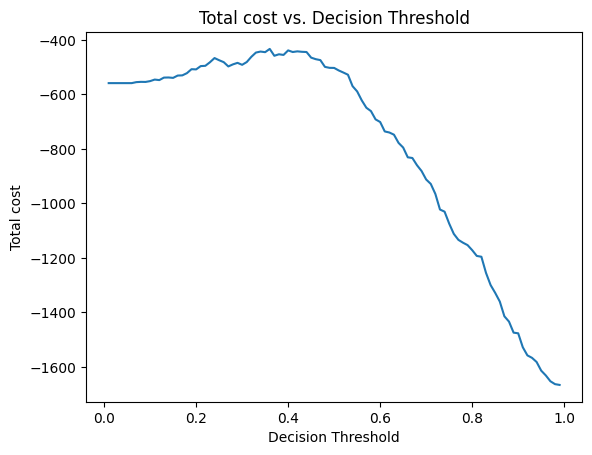

In [38]:
cb_column = 'A'
test_predictions_log_2['y_predicted_proba_log']= best_pipeline_log_reg.predict_proba(test_predictions_log_2.drop(y, axis=1))[:, 1]
best_threshold_log, AMC_log, lowest_cost_log = compute_best_threshold_2(test_predictions_log_2, best_pipeline_log_reg, y,cb_column, y_predicted_proba_col_name="y_predicted_proba_log", instance_dependent_cost_type= 'churn_2' )

Decision Threshold: 0.01, Test cost/loss = -556.03


Decision Threshold: 0.02, Test cost/loss = -535.03
Decision Threshold: 0.03, Test cost/loss = -529.92
Decision Threshold: 0.04, Test cost/loss = -519.86
Decision Threshold: 0.05, Test cost/loss = -497.94
Decision Threshold: 0.06, Test cost/loss = -486.39
Decision Threshold: 0.07, Test cost/loss = -480.32
Decision Threshold: 0.08, Test cost/loss = -473.77
Decision Threshold: 0.09, Test cost/loss = -458.65
Decision Threshold: 0.10, Test cost/loss = -461.10
Decision Threshold: 0.11, Test cost/loss = -456.84
Decision Threshold: 0.12, Test cost/loss = -433.65
Decision Threshold: 0.13, Test cost/loss = -437.33
Decision Threshold: 0.14, Test cost/loss = -418.01
Decision Threshold: 0.15, Test cost/loss = -420.40
Decision Threshold: 0.16, Test cost/loss = -407.60
Decision Threshold: 0.17, Test cost/loss = -401.13
Decision Threshold: 0.18, Test cost/loss = -391.33
Decision Threshold: 0.19, Test cost/loss = -392.59
Decision Threshold: 0.20, Test cost/loss = -386.26
Decision Threshold: 0.21, Test

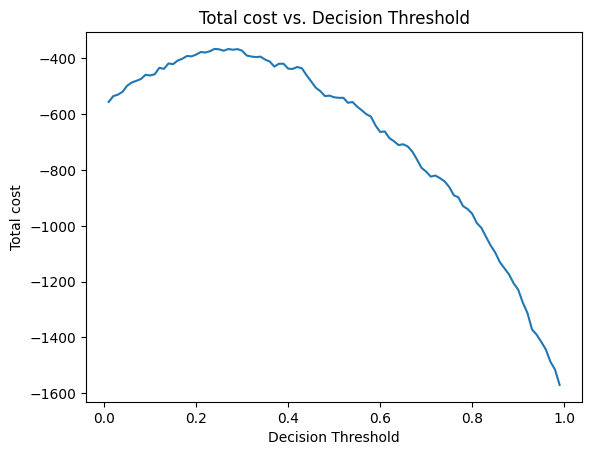

In [39]:
test_predictions_xgb_2['y_predicted_proba_xgb']= best_pipeline_xgb.predict_proba(test_predictions_xgb_2.drop(y, axis=1))[:, 1]
best_threshold_xgb, AMC_xgb, lowest_cost_xgb = compute_best_threshold_2(test_predictions_xgb_2, best_pipeline_xgb, y, cb_column, y_predicted_proba_col_name="y_predicted_proba_xgb", instance_dependent_cost_type= 'churn_2')

# emp metric


In [40]:
test_predictions_log_2 = add_eap_ep(
    train=train, 
    test=test_predictions_log_2, 
    y_col_name=y, 
    best_pipeline=best_pipeline_log_reg, 
    cb_column=cb_column, 
    predicted_proba_col_name='y_predicted_proba_log', 
    churn_label= 1, 
    instance_dependent_cost_type="churn_2")
test_predictions_xgb_2 = add_eap_ep(
    train=train, 
    test=test_predictions_xgb_2, 
    y_col_name=y, 
    best_pipeline=best_pipeline_xgb, 
    cb_column=cb_column, 
    predicted_proba_col_name="y_predicted_proba_xgb", 
    churn_label=1, 
    instance_dependent_cost_type="churn_2")

c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:318: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EAP'] = test_actual_label_0[predicted_proba_col_name]*test_actual_label_0['FP'] + \
c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:320: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EP'] = estim

In [41]:
print(test_predictions_log_2['EAP'].sum())
print(test_predictions_log_2['EP'].sum())


print('EAP : ', test_predictions_log_2['EAP'].sum()/len(test_predictions_log_2))
print('EP : ', test_predictions_log_2['EP'].sum()/len(test_predictions_log_2))

-788.2558330838361
-1440.7071173463942
EAP :  -0.3941279165419181
EP :  -0.7203535586731971


In [42]:
print(test_predictions_xgb_2['EAP'].sum())
print(test_predictions_xgb_2['EP'].sum())


print('EAP : ', test_predictions_xgb_2['EAP'].sum()/len(test_predictions_xgb_2))
print('EP : ', test_predictions_xgb_2['EP'].sum()/len(test_predictions_xgb_2))

-686.8171940449806
-1440.7071173463942
EAP :  -0.3434085970224903
EP :  -0.7203535586731971


# cost curves test

In [43]:
total_fp_log = 0

for i in range(0,2000):
    if test_predictions_log['churn_encoded'].iloc[i] == 0 and test_predictions_log['y_predicted'].iloc[i]==1:
        total_fp_log += test_predictions_log['FP'].iloc[i]
    else:
        total_fp_log += 0

print(total_fp_log)

average_fp_log = total_fp_log/2000
print( average_fp_log)

323.27745123133536
0.1616387256156677


In [44]:
total_fn_log = 0

for i in range(0,2000):
    if test_predictions_log['churn_encoded'].iloc[i] == 1 and test_predictions_log['y_predicted'].iloc[i]==0:
        total_fn_log += test_predictions_log['FN'].iloc[i]
    else:
        total_fn_log += 0

print(total_fn_log)

average_fn_log = total_fn_log/2000
print( average_fn_log)

391.8950965743494
0.1959475482871747


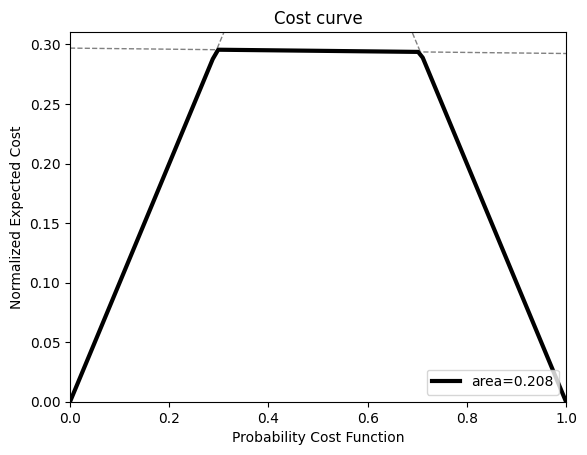

In [45]:
cost_fn_log = average_fn_log
# C(+|-)
cost_fp_log = average_fp_log

# Ground truth
truth = test_predictions_log['churn_encoded']
#  <a list of 0 (negative class) or 1 (positive class)>
# Predictions from a classifier
score = test_predictions_log['y_predicted']
# best_pipeline_log_reg.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]
# <a list of [0,1] class probabilities>

# %% OUTPUTS

# 1D-array of x-axis values (normalized PC)
pc = None
# list of lines as (slope, intercept)
lines = []
# lower envelope of the list of lines as a 1D-array of y-axis values (NEC)
lower_envelope = []
# area under the lower envelope (the smaller, the better)
area = None

# %% COMPUTATION

# points from the roc curve, because a point in the ROC space <=> a line in the cost space
roc_fpr, roc_tpr, _ = roc_curve(truth, score)

# compute the normalized p(+)*C(-|+)
thresholds = np.arange(0, 1.01, .01)
pc = (thresholds*cost_fn_log) / (thresholds*cost_fn_log + (1-thresholds)*cost_fp_log)

# compute a line in the cost space for each point in the roc space
for fpr, tpr in zip(roc_fpr, roc_tpr):
    slope = (1-tpr-fpr)
    intercept = fpr
    lines.append((slope, intercept))

# compute the lower envelope
for x_value in pc:
    y_value = min([slope*x_value+intercept for slope, intercept in lines])
    lower_envelope.append(max(0, y_value))
lower_envelope = np.array(lower_envelope)

# compute the area under the lower envelope using the composite trapezoidal rule
area = np.trapz(lower_envelope, pc)

# %% EXAMPLE OF PLOT

# display each line as a thin dashed line
for slope, intercept in lines:
    plt.plot(pc, slope*pc+intercept, color="grey", lw=1, linestyle="--")

# display the lower envelope as a thicker black line
plt.plot(pc, lower_envelope, color="black", lw=3, label="area={:.3f}".format(area))

# plot parameters
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05*max(lower_envelope)])
plt.xlabel("Probability Cost Function")
plt.ylabel("Normalized Expected Cost")
plt.title("Cost curve")
plt.legend(loc="lower right")

plt.show()

In [46]:
total_fp_xgb = 0

for i in range(0,2000):
    if test_predictions_xgb['churn_encoded'].iloc[i] == 0 and test_predictions_xgb['y_predicted'].iloc[i]==1:
        total_fp_xgb += test_predictions_xgb['FP'].iloc[i]
    else:
        total_fp_xgb += 0

print(total_fp_xgb)

average_fp_xgb = total_fp_xgb/2000
print( average_fp_xgb)

180.16152331476553
0.09008076165738277


In [47]:
total_fn_xgb = 0

for i in range(0,2000):
    if test_predictions_xgb['churn_encoded'].iloc[i] == 1 and test_predictions_xgb['y_predicted'].iloc[i]==0:
        total_fn_xgb += test_predictions_xgb['FN'].iloc[i]
    else:
        total_fn_xgb += 0

print(total_fn_xgb)

average_fn_xgb = total_fn_xgb/2000
print( average_fn_xgb)

545.9056989535635
0.2729528494767818


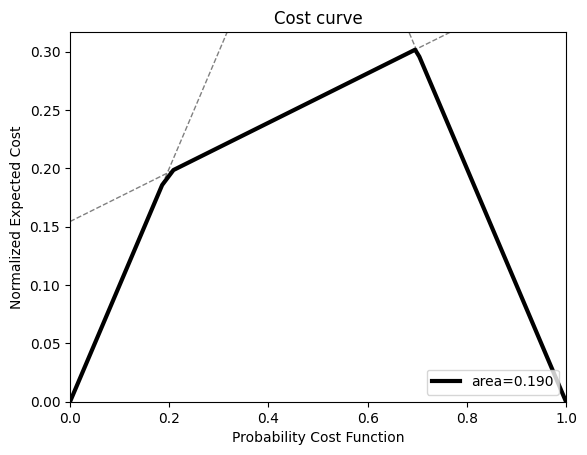

In [48]:
cost_fn_xgb = average_fn_xgb
# C(+|-)
cost_fp_xgb = average_fp_xgb

# Ground truth
truth = test_predictions_xgb['churn_encoded']
#  <a list of 0 (negative class) or 1 (positive class)>
# Predictions from a classifier
score = test_predictions_xgb['y_predicted']
# best_pipeline_log_reg.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]
# <a list of [0,1] class probabilities>

# %% OUTPUTS

# 1D-array of x-axis values (normalized PC)
pc = None
# list of lines as (slope, intercept)
lines = []
# lower envelope of the list of lines as a 1D-array of y-axis values (NEC)
lower_envelope = []
# area under the lower envelope (the smaller, the better)
area = None

# %% COMPUTATION

# points from the roc curve, because a point in the ROC space <=> a line in the cost space
roc_fpr, roc_tpr, _ = roc_curve(truth, score)

# compute the normalized p(+)*C(-|+)
thresholds = np.arange(0, 1.01, .01)
pc = (thresholds*cost_fn_xgb) / (thresholds*cost_fn_xgb + (1-thresholds)*cost_fp_xgb)

# compute a line in the cost space for each point in the roc space
for fpr, tpr in zip(roc_fpr, roc_tpr):
    slope = (1-tpr-fpr)
    intercept = fpr
    lines.append((slope, intercept))

# compute the lower envelope
for x_value in pc:
    y_value = min([slope*x_value+intercept for slope, intercept in lines])
    lower_envelope.append(max(0, y_value))
lower_envelope = np.array(lower_envelope)

# compute the area under the lower envelope using the composite trapezoidal rule
area = np.trapz(lower_envelope, pc)

# %% EXAMPLE OF PLOT

# display each line as a thin dashed line
for slope, intercept in lines:
    plt.plot(pc, slope*pc+intercept, color="grey", lw=1, linestyle="--")

# display the lower envelope as a thicker black line
plt.plot(pc, lower_envelope, color="black", lw=3, label="area={:.3f}".format(area))

# plot parameters
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05*max(lower_envelope)])
plt.xlabel("Probability Cost Function")
plt.ylabel("Normalized Expected Cost")
plt.title("Cost curve")
plt.legend(loc="lower right")

plt.show()

# from here on we calculate the amc, e-amc, mp and emp but with the fraud detection cost and benefit matrices

# total cost 50% decision threshold

In [49]:
test_predictions_log_fraud = test.copy(deep=True)
test_predictions_log_fraud["y_predicted"] = best_pipeline_log_reg.predict(test_predictions_log_fraud.drop(y, axis=1))
test_predictions_log_fraud["churn_encoded"] = fit_le.transform(test_predictions_log_fraud["exited"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_log_fraud['A'] = impute.fit_transform(
    (test_predictions_log_fraud["balance"]*test_predictions_log_fraud["credit_score"]*2000).to_frame())[:, 0]
scaler = MinMaxScaler()

# Fit and transform the cb_cyolumn using the scaler
test_predictions_log_fraud['A'] = scaler.fit_transform(test_predictions_log_fraud['A'].values.reshape(-1, 1))


# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_log_fraud['instance_cost'] = test_predictions_log_fraud.apply(lambda row: instance_dependent_cost_fraud(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_log_fraud["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_log_fraud["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_log_fraud[['exited', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_log_fraud['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_log_fraud['instance_cost'].sum()/len(test_predictions_log_fraud))

Test cost/loss = 473.
 total cost/loss average :  0.23650816448117862


In [50]:
test_predictions_xgb_fraud = test.copy(deep=True)
test_predictions_xgb_fraud["y_predicted"] = best_pipeline_xgb.predict(test_predictions_xgb_fraud.drop(y, axis=1))
test_predictions_xgb_fraud["churn_encoded"] = fit_le.transform(test_predictions_xgb_fraud["exited"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_xgb_fraud['A'] = impute.fit_transform(
    (test_predictions_xgb_fraud["balance"]*test_predictions_xgb_fraud["credit_score"]*2000).to_frame())[:, 0]
scaler = MinMaxScaler()

# Fit and transform the cb_column using the scaler
test_predictions_xgb_fraud['A'] = scaler.fit_transform(test_predictions_xgb_fraud['A'].values.reshape(-1, 1))


# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_xgb_fraud['instance_cost'] = test_predictions_xgb_fraud.apply(lambda row: instance_dependent_cost_fraud(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_xgb_fraud["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_xgb_fraud["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_xgb_fraud[['exited', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_xgb_fraud['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_xgb_fraud['instance_cost'].sum()/len(test_predictions_xgb_fraud))

Test cost/loss = 246.
 total cost/loss average :  0.12301137303539489


# amc metric

Decision Threshold: 0.01, Test cost/loss = 1593.00
Decision Threshold: 0.02, Test cost/loss = 1593.00
Decision Threshold: 0.03, Test cost/loss = 1593.00
Decision Threshold: 0.04, Test cost/loss = 1591.00


Decision Threshold: 0.05, Test cost/loss = 1587.00
Decision Threshold: 0.06, Test cost/loss = 1582.00
Decision Threshold: 0.07, Test cost/loss = 1573.00
Decision Threshold: 0.08, Test cost/loss = 1564.00
Decision Threshold: 0.09, Test cost/loss = 1546.00
Decision Threshold: 0.10, Test cost/loss = 1527.00
Decision Threshold: 0.11, Test cost/loss = 1509.00
Decision Threshold: 0.12, Test cost/loss = 1486.00
Decision Threshold: 0.13, Test cost/loss = 1467.00
Decision Threshold: 0.14, Test cost/loss = 1447.00
Decision Threshold: 0.15, Test cost/loss = 1418.00
Decision Threshold: 0.16, Test cost/loss = 1379.00
Decision Threshold: 0.17, Test cost/loss = 1353.00
Decision Threshold: 0.18, Test cost/loss = 1327.00
Decision Threshold: 0.19, Test cost/loss = 1300.00
Decision Threshold: 0.20, Test cost/loss = 1267.00
Decision Threshold: 0.21, Test cost/loss = 1240.00
Decision Threshold: 0.22, Test cost/loss = 1199.00
Decision Threshold: 0.23, Test cost/loss = 1165.00
Decision Threshold: 0.24, Test 

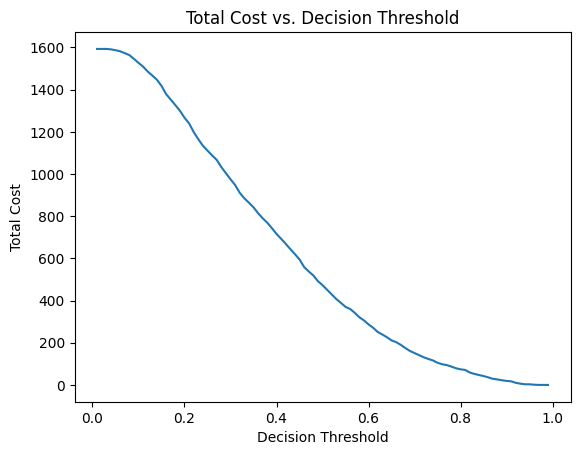

In [51]:
cb_column = 'A'
test_predictions_log_fraud['y_predicted_proba_log']= best_pipeline_log_reg.predict_proba(test_predictions_log_fraud.drop(y, axis=1))[:, 1]
best_threshold_log, AMC_log, lowest_cost_log = compute_best_threshold(test_predictions_log_fraud, best_pipeline_log_reg, y,cb_column,y_predicted_proba_col_name="y_predicted_proba_log", instance_dependent_cost_type = 'fraud' )

Decision Threshold: 0.01, Test cost/loss = 1530.00
Decision Threshold: 0.02, Test cost/loss = 1410.00
Decision Threshold: 0.03, Test cost/loss = 1336.00
Decision Threshold: 0.04, Test cost/loss = 1264.00
Decision Threshold: 0.05, Test cost/loss = 1204.00
Decision Threshold: 0.06, Test cost/loss = 1150.00
Decision Threshold: 0.07, Test cost/loss = 1099.00
Decision Threshold: 0.08, Test cost/loss = 1049.00
Decision Threshold: 0.09, Test cost/loss = 1001.00
Decision Threshold: 0.10, Test cost/loss = 960.00
Decision Threshold: 0.11, Test cost/loss = 920.00
Decision Threshold: 0.12, Test cost/loss = 884.00
Decision Threshold: 0.13, Test cost/loss = 855.00
Decision Threshold: 0.14, Test cost/loss = 816.00
Decision Threshold: 0.15, Test cost/loss = 794.00
Decision Threshold: 0.16, Test cost/loss = 765.01
Decision Threshold: 0.17, Test cost/loss = 740.01
Decision Threshold: 0.18, Test cost/loss = 709.01
Decision Threshold: 0.19, Test cost/loss = 684.01
Decision Threshold: 0.20, Test cost/loss 

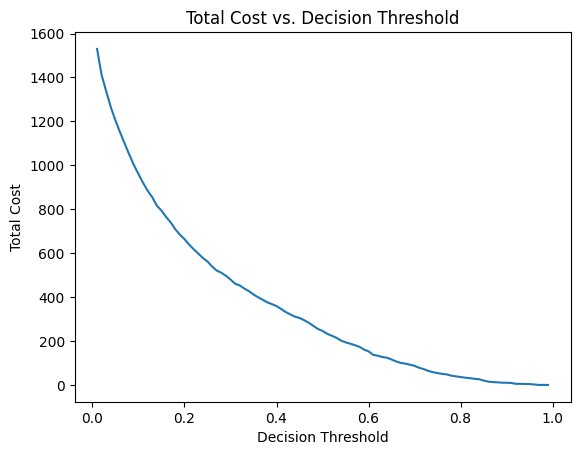

In [52]:
test_predictions_xgb_fraud['y_predicted_proba_xgb']= best_pipeline_xgb.predict_proba(test_predictions_xgb_fraud.drop(y, axis=1))[:, 1]
best_threshold_xgb, AMC_xgb, lowest_cost_xgb = compute_best_threshold(test_predictions_xgb_fraud, best_pipeline_xgb, y, cb_column, y_predicted_proba_col_name="y_predicted_proba_xgb", instance_dependent_cost_type = 'fraud')

# e-amc metric

In [53]:
test_predictions_log_fraud = add_eap_ep(
    train=train, 
    test=test_predictions_log_fraud, 
    y_col_name=y, 
    best_pipeline=best_pipeline_log_reg, 
    cb_column=cb_column, 
    predicted_proba_col_name='y_predicted_proba_log', 
    churn_label=1, 
    instance_dependent_cost_type="fraud")
test_predictions_xgb_fraud = add_eap_ep(
    train=train, 
    test=test_predictions_xgb_fraud, 
    y_col_name=y, 
    best_pipeline=best_pipeline_xgb, 
    cb_column=cb_column, 
    predicted_proba_col_name="y_predicted_proba_xgb", 
    churn_label=1, 
    instance_dependent_cost_type="fraud")

c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:318: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EAP'] = test_actual_label_0[predicted_proba_col_name]*test_actual_label_0['FP'] + \
c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:320: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EP'] = estim

In [54]:
print(test_predictions_log_fraud['EAP'].sum())
print(test_predictions_log_fraud['EP'].sum())


print('EAP : ', test_predictions_log_fraud['EAP'].sum()/len(test_predictions_log_fraud))
print('EP : ', test_predictions_log_fraud['EP'].sum()/len(test_predictions_log_fraud))

628.3106667433108
324.62903768295394
EAP :  0.3141553333716554
EP :  0.16231451884147696


In [55]:
print(test_predictions_xgb_fraud['EAP'].sum())
print(test_predictions_xgb_fraud['EP'].sum())


print('EAP : ', test_predictions_xgb_fraud['EAP'].sum()/len(test_predictions_xgb_fraud))
print('EP : ', test_predictions_xgb_fraud['EP'].sum()/len(test_predictions_xgb_fraud))

370.04430072191985
324.62903768295394
EAP :  0.18502215036095992
EP :  0.16231451884147696


# mp at 50% threshold

In [56]:
test_predictions_log_fraud_2 = test.copy(deep=True)
test_predictions_log_fraud_2["y_predicted"] = best_pipeline_log_reg.predict(test_predictions_log_fraud_2.drop(y, axis=1))
test_predictions_log_fraud_2["churn_encoded"] = fit_le.transform(test_predictions_log_fraud_2["exited"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_log_fraud_2['A'] = impute.fit_transform(
    (test_predictions_log_fraud_2["balance"]*test_predictions_log_fraud_2["credit_score"]*2000).to_frame())[:, 0]
scaler = MinMaxScaler()

# Fit and transform the cb_cyolumn using the scaler
test_predictions_log_fraud_2['A'] = scaler.fit_transform(test_predictions_log_fraud_2['A'].values.reshape(-1, 1))


# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_log_fraud_2['instance_cost'] = test_predictions_log_fraud_2.apply(lambda row: instance_dependent_cost_fraud_2(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_log_fraud_2["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_log_fraud_2["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_log_fraud_2[['exited', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_log_fraud_2['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_log_fraud_2['instance_cost'].sum()/len(test_predictions_log_fraud_2))

Test cost/loss = -185.
 total cost/loss average :  -0.09250816448117863


In [57]:
test_predictions_xgb_fraud_2 = test.copy(deep=True)
test_predictions_xgb_fraud_2["y_predicted"] = best_pipeline_xgb.predict(test_predictions_xgb_fraud_2.drop(y, axis=1))
test_predictions_xgb_fraud_2["churn_encoded"] = fit_le.transform(test_predictions_xgb_fraud_2["exited"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_xgb_fraud_2['A'] = impute.fit_transform(
    (test_predictions_xgb_fraud_2["balance"]*test_predictions_xgb_fraud_2["credit_score"]*2000).to_frame())[:, 0]
scaler = MinMaxScaler()

# Fit and transform the cb_column using the scaler
test_predictions_xgb_fraud_2['A'] = scaler.fit_transform(test_predictions_xgb_fraud_2['A'].values.reshape(-1, 1))


# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_xgb_fraud_2['instance_cost'] = test_predictions_xgb_fraud_2.apply(lambda row: instance_dependent_cost_fraud_2(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_xgb_fraud_2["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_xgb_fraud_2["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_xgb_fraud_2[['exited', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_xgb_fraud_2['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_xgb_fraud_2['instance_cost'].sum()/len(test_predictions_xgb_fraud_2))

Test cost/loss = 12.
 total cost/loss average :  0.005988626964605136


# mp metric

Decision Threshold: 0.01, Test cost/loss = -1186.00
Decision Threshold: 0.02, Test cost/loss = -1186.00
Decision Threshold: 0.03, Test cost/loss = -1186.00
Decision Threshold: 0.04, Test cost/loss = -1185.00
Decision Threshold: 0.05, Test cost/loss = -1181.00


Decision Threshold: 0.06, Test cost/loss = -1176.00
Decision Threshold: 0.07, Test cost/loss = -1167.00
Decision Threshold: 0.08, Test cost/loss = -1158.00
Decision Threshold: 0.09, Test cost/loss = -1142.00
Decision Threshold: 0.10, Test cost/loss = -1123.00
Decision Threshold: 0.11, Test cost/loss = -1106.00
Decision Threshold: 0.12, Test cost/loss = -1084.00
Decision Threshold: 0.13, Test cost/loss = -1065.00
Decision Threshold: 0.14, Test cost/loss = -1046.00
Decision Threshold: 0.15, Test cost/loss = -1019.00
Decision Threshold: 0.16, Test cost/loss = -982.00
Decision Threshold: 0.17, Test cost/loss = -957.00
Decision Threshold: 0.18, Test cost/loss = -931.00
Decision Threshold: 0.19, Test cost/loss = -905.00
Decision Threshold: 0.20, Test cost/loss = -875.00
Decision Threshold: 0.21, Test cost/loss = -848.00
Decision Threshold: 0.22, Test cost/loss = -813.00
Decision Threshold: 0.23, Test cost/loss = -780.00
Decision Threshold: 0.24, Test cost/loss = -751.00
Decision Threshold: 0

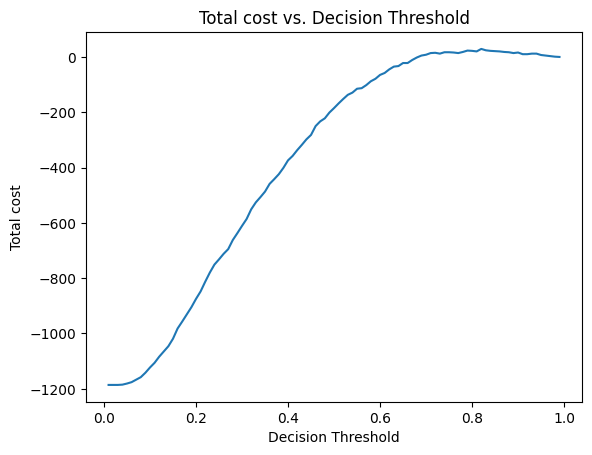

In [58]:
cb_column = 'A'
test_predictions_log_fraud_2['y_predicted_proba_log']= best_pipeline_log_reg.predict_proba(test_predictions_log_fraud_2.drop(y, axis=1))[:, 1]
best_threshold_log, AMC_log, lowest_cost_log = compute_best_threshold_2(test_predictions_log_fraud_2, best_pipeline_log_reg, y,cb_column,y_predicted_proba_col_name="y_predicted_proba_log", instance_dependent_cost_type = 'fraud_2' )

Decision Threshold: 0.01, Test cost/loss = -1124.00


Decision Threshold: 0.02, Test cost/loss = -1007.00
Decision Threshold: 0.03, Test cost/loss = -937.00
Decision Threshold: 0.04, Test cost/loss = -867.00
Decision Threshold: 0.05, Test cost/loss = -808.00
Decision Threshold: 0.06, Test cost/loss = -755.00
Decision Threshold: 0.07, Test cost/loss = -709.00
Decision Threshold: 0.08, Test cost/loss = -661.00
Decision Threshold: 0.09, Test cost/loss = -614.00
Decision Threshold: 0.10, Test cost/loss = -579.00
Decision Threshold: 0.11, Test cost/loss = -541.00
Decision Threshold: 0.12, Test cost/loss = -506.00
Decision Threshold: 0.13, Test cost/loss = -480.00
Decision Threshold: 0.14, Test cost/loss = -443.00
Decision Threshold: 0.15, Test cost/loss = -423.00
Decision Threshold: 0.16, Test cost/loss = -395.01
Decision Threshold: 0.17, Test cost/loss = -372.01
Decision Threshold: 0.18, Test cost/loss = -343.01
Decision Threshold: 0.19, Test cost/loss = -322.01
Decision Threshold: 0.20, Test cost/loss = -303.01
Decision Threshold: 0.21, Tes

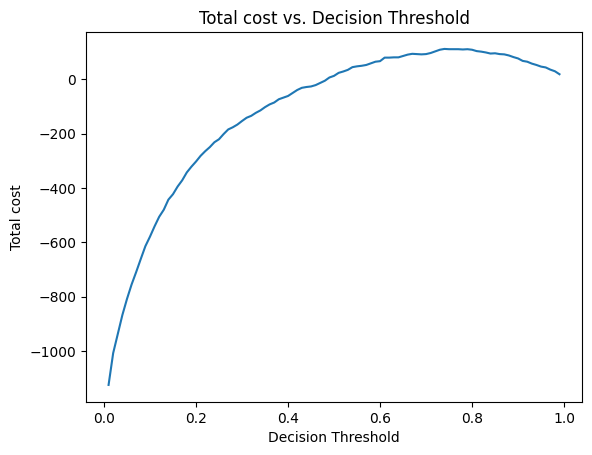

In [59]:
test_predictions_xgb_fraud_2['y_predicted_proba_xgb']= best_pipeline_xgb.predict_proba(test_predictions_xgb_fraud_2.drop(y, axis=1))[:, 1]
best_threshold_xgb, AMC_xgb, lowest_cost_xgb = compute_best_threshold_2(test_predictions_xgb_fraud_2, best_pipeline_xgb, y, cb_column, y_predicted_proba_col_name="y_predicted_proba_xgb", instance_dependent_cost_type = 'fraud_2')

# emp-metric

In [60]:
test_predictions_log_fraud_2 = add_eap_ep(
    train=train, 
    test=test_predictions_log_fraud_2, 
    y_col_name=y, 
    best_pipeline=best_pipeline_log_reg, 
    cb_column=cb_column, 
    predicted_proba_col_name='y_predicted_proba_log', 
    churn_label=1, 
    instance_dependent_cost_type="fraud_2")
test_predictions_xgb_fraud_2 = add_eap_ep(
    train=train, 
    test=test_predictions_xgb_fraud_2, 
    y_col_name=y, 
    best_pipeline=best_pipeline_xgb, 
    cb_column=cb_column, 
    predicted_proba_col_name="y_predicted_proba_xgb", 
    churn_label=1, 
    instance_dependent_cost_type="fraud_2")

c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:318: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EAP'] = test_actual_label_0[predicted_proba_col_name]*test_actual_label_0['FP'] + \
c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:320: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EP'] = estim

In [61]:
print(test_predictions_log_fraud_2['EAP'].sum())
print(test_predictions_log_fraud_2['EP'].sum())


print('EAP : ', test_predictions_log_fraud_2['EAP'].sum()/len(test_predictions_log_fraud_2))
print('EP : ', test_predictions_log_fraud_2['EP'].sum()/len(test_predictions_log_fraud_2))

-378.7076121207285
-241.70278768295395
EAP :  -0.18935380606036425
EP :  -0.12085139384147697


In [62]:
print(test_predictions_xgb_fraud_2['EAP'].sum())
print(test_predictions_xgb_fraud_2['EP'].sum())


print('EAP : ', test_predictions_xgb_fraud_2['EAP'].sum()/len(test_predictions_xgb_fraud_2))
print('EP : ', test_predictions_xgb_fraud_2['EP'].sum()/len(test_predictions_xgb_fraud_2))

-123.63065531496773
-241.70278768295395
EAP :  -0.06181532765748386
EP :  -0.12085139384147697


# cost curves

In [63]:
total_fp_log_2 = 0

for i in range(0,2000):
    if test_predictions_log_fraud['churn_encoded'].iloc[i] == 0 and test_predictions_log_fraud['y_predicted'].iloc[i]==1:
        total_fp_log_2 += test_predictions_log_fraud['FP'].iloc[i]
    else:
        total_fp_log_2 += 0

print(total_fp_log_2)

average_fp_log_2 = total_fp_log_2/2000
print( average_fp_log_2)

473
0.2365


In [64]:
total_fn_log_2 = 0

for i in range(0,2000):
    if test_predictions_log_fraud['churn_encoded'].iloc[i] == 1 and test_predictions_log_fraud['y_predicted'].iloc[i]==0:
        total_fn_log_2 += test_predictions_log_fraud['FN'].iloc[i]
    else:
        total_fn_log_2 += 0

print(total_fn_log_2)

average_fn_log_2 = total_fn_log_2/2000
print( average_fn_log_2)

0.016328962357264564
8.164481178632282e-06


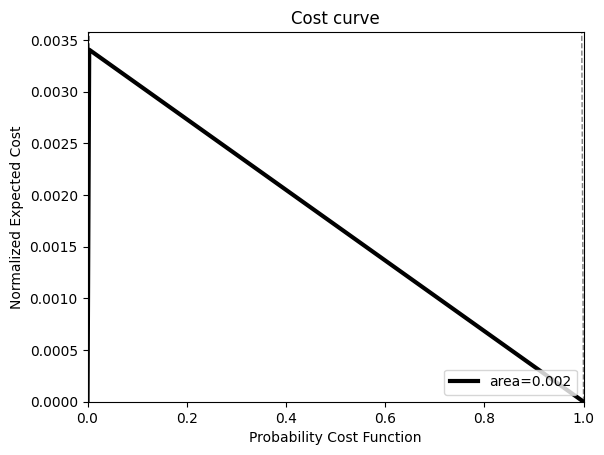

In [65]:
cost_fn_log_2 = average_fn_log_2
# C(+|-)
cost_fp_log_2 = average_fp_log_2

# Ground truth
truth = test_predictions_log_fraud['churn_encoded']
#  <a list of 0 (negative class) or 1 (positive class)>
# Predictions from a classifier
score = test_predictions_log_fraud['y_predicted']
# best_pipeline_log_reg.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]
# <a list of [0,1] class probabilities>

# %% OUTPUTS

# 1D-array of x-axis values (normalized PC)
pc = None
# list of lines as (slope, intercept)
lines = []
# lower envelope of the list of lines as a 1D-array of y-axis values (NEC)
lower_envelope = []
# area under the lower envelope (the smaller, the better)
area = None

# %% COMPUTATION

# points from the roc curve, because a point in the ROC space <=> a line in the cost space
roc_fpr, roc_tpr, _ = roc_curve(truth, score)

# compute the normalized p(+)*C(-|+)
thresholds = np.arange(0, 1.01, .01)
pc = (thresholds*cost_fn_log_2) / (thresholds*cost_fn_log_2 + (1-thresholds)*cost_fp_log_2)

# compute a line in the cost space for each point in the roc space
for fpr, tpr in zip(roc_fpr, roc_tpr):
    slope = (1-tpr-fpr)
    intercept = fpr
    lines.append((slope, intercept))

# compute the lower envelope
for x_value in pc:
    y_value = min([slope*x_value+intercept for slope, intercept in lines])
    lower_envelope.append(max(0, y_value))
lower_envelope = np.array(lower_envelope)

# compute the area under the lower envelope using the composite trapezoidal rule
area = np.trapz(lower_envelope, pc)

# %% EXAMPLE OF PLOT

# display each line as a thin dashed line
for slope, intercept in lines:
    plt.plot(pc, slope*pc+intercept, color="grey", lw=1, linestyle="--")

# display the lower envelope as a thicker black line
plt.plot(pc, lower_envelope, color="black", lw=3, label="area={:.3f}".format(area))

# plot parameters
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05*max(lower_envelope)])
plt.xlabel("Probability Cost Function")
plt.ylabel("Normalized Expected Cost")
plt.title("Cost curve")
plt.legend(loc="lower right")

plt.show()

In [66]:
total_fp_xgb_2 = 0

for i in range(0,2000):
    if test_predictions_xgb_fraud['churn_encoded'].iloc[i] == 0 and test_predictions_xgb_fraud['y_predicted'].iloc[i]==1:
        total_fp_xgb_2 += test_predictions_xgb_fraud['FP'].iloc[i]
    else:
        total_fp_xgb_2 += 0

print(total_fp_xgb_2)

average_fp_xgb_2 = total_fp_xgb_2/2000
print( average_fp_xgb_2)

246
0.123


In [67]:
total_fn_xgb_2 = 0

for i in range(0,2000):
    if test_predictions_xgb_fraud['churn_encoded'].iloc[i] == 1 and test_predictions_xgb_fraud['y_predicted'].iloc[i]==0:
        total_fn_xgb_2 += test_predictions_xgb_fraud['FN'].iloc[i]
    else:
        total_fn_xgb_2 += 0

print(total_fn_xgb_2)

average_fn_xgb_2 = total_fn_xgb_2/2000
print( average_fn_xgb_2)

0.02274607078973182
1.137303539486591e-05


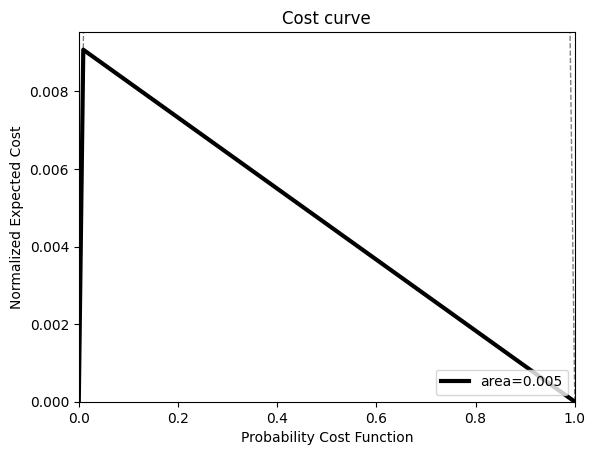

In [68]:
#C(-|+)
cost_fn_xgb_2 = average_fn_xgb_2
# C(+|-)
cost_fp_xgb_2 = average_fp_xgb_2

# Ground truth
truth = test_predictions_xgb_fraud['churn_encoded']
#  <a list of 0 (negative class) or 1 (positive class)>
# Predictions from a classifier
score = test_predictions_xgb_fraud['y_predicted']
# best_pipeline_log_reg.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]
# <a list of [0,1] class probabilities>

# %% OUTPUTS

# 1D-array of x-axis values (normalized PC)
pc = None
# list of lines as (slope, intercept)
lines = []
# lower envelope of the list of lines as a 1D-array of y-axis values (NEC)
lower_envelope = []
# area under the lower envelope (the smaller, the better)
area = None

# %% COMPUTATION

# points from the roc curve, because a point in the ROC space <=> a line in the cost space
roc_fpr, roc_tpr, _ = roc_curve(truth, score)

# compute the normalized p(+)*C(-|+)
thresholds = np.arange(0, 1.01, .01)
pc = (thresholds*cost_fn_xgb_2) / (thresholds*cost_fn_xgb_2 + (1-thresholds)*cost_fp_xgb_2)

# compute a line in the cost space for each point in the roc space
for fpr, tpr in zip(roc_fpr, roc_tpr):
    slope = (1-tpr-fpr)
    intercept = fpr
    lines.append((slope, intercept))

# compute the lower envelope
for x_value in pc:
    y_value = min([slope*x_value+intercept for slope, intercept in lines])
    lower_envelope.append(max(0, y_value))
lower_envelope = np.array(lower_envelope)

# compute the area under the lower envelope using the composite trapezoidal rule
area = np.trapz(lower_envelope, pc)

# %% EXAMPLE OF PLOT

# display each line as a thin dashed line
for slope, intercept in lines:
    plt.plot(pc, slope*pc+intercept, color="grey", lw=1, linestyle="--")

# display the lower envelope as a thicker black line
plt.plot(pc, lower_envelope, color="black", lw=3, label="area={:.3f}".format(area))

# plot parameters
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05*max(lower_envelope)])
plt.xlabel("Probability Cost Function")
plt.ylabel("Normalized Expected Cost")
plt.title("Cost curve")
plt.legend(loc="lower right")

plt.show()